In [1]:
import sys
sys.path.append('/home/lenovo/code/TreeSeg/notebooks/')
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import rasterio.warp             # Reproect raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)
tf.config.list_physical_devices('GPU')
# from configx import Preprocessing_prediction
# config = Preprocessing_prediction.Configuration(folder="full_area3")


2022-12-09 17:56:44.601419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 17:56:44.679721: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 17:56:44.696281: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-09 17:56:45.076718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0


2022-12-09 17:56:45.952298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 17:56:45.969728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 17:56:45.969834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

# Define the model and compile it
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'
model_path = "/home/lenovo/code/TreeSeg/notebooks/saved_models/UNet/no-norm-model-1209.h5"
model = load_model(model_path, custom_objects={'tversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity}, compile=False)

2022-12-09 17:56:51.743175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 17:56:51.744058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 17:56:51.744183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 17:56:51.744237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [3]:
def read_method(method:str=''):
    if method == 'Image' or method == '':
        return Image.open
    if method == 'rasterio':
        return rasterio.open
    if method == 'numpy':
        return np.load

In [9]:
result_dir = '/home/lenovo/treeseg-dataset/inference_train_data/merge_result_128_nonorm'
old_result_dir = '/home/lenovo/treeseg-dataset/inference_train_data/merge_result_128'
tif_dir = '/home/lenovo/treeseg-dataset/inference_train_data/tif'
data = read_method('rasterio')(f'{result_dir}/merge-result-segmap.png').read(1)
old_data = read_method('rasterio')(f'{old_result_dir}/merge-result-segmap.png').read(1)
pan = read_method('rasterio')(f'{tif_dir}/pan-0.tif').read(1)
ndvi = read_method('rasterio')(f'{tif_dir}/ndvi-0.tif').read(1)

<AxesSubplot:>

<AxesSubplot:>

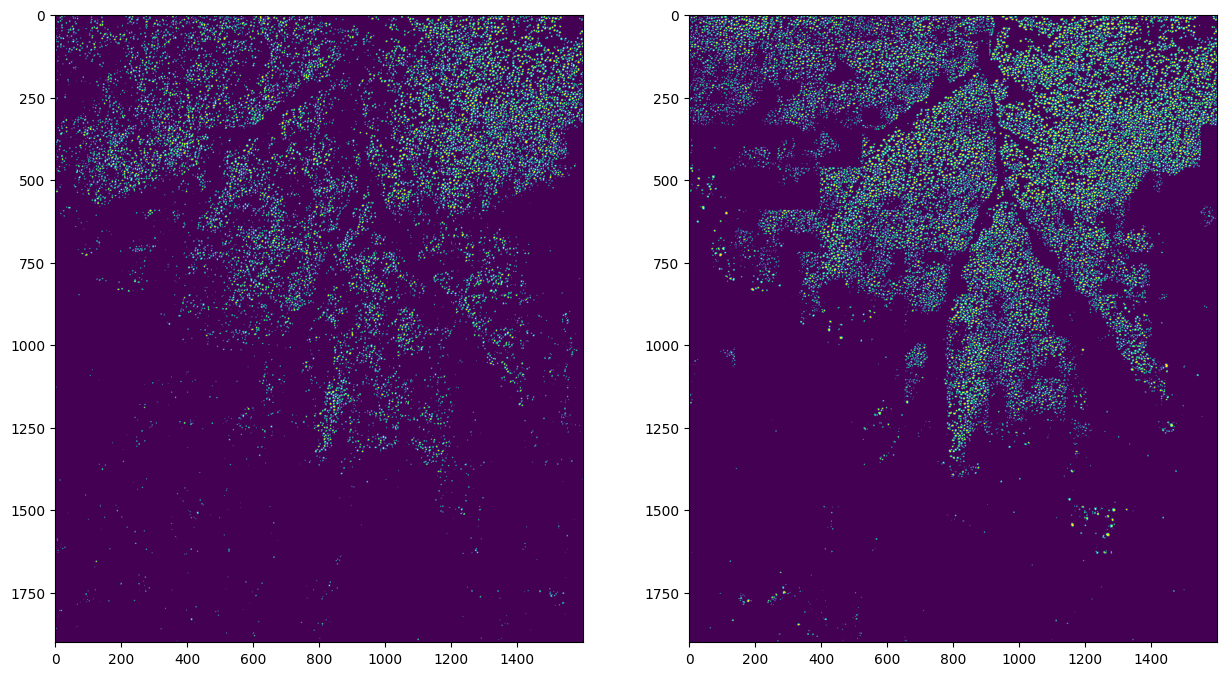

<AxesSubplot:>

<AxesSubplot:>

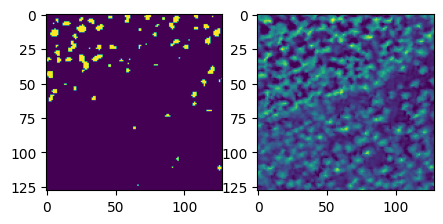

In [10]:
local = data[23600:25500,6900:8500]
old_local = old_data[23600:25500,6900:8500]
local_pan = pan[23600:25500,6900:8500]
local_ndvi = ndvi[23600:25500,6900:8500]

# 24064-24192, 7168:7296
ll1 = data[24064:24192, 7168:7296]
pan_ll1 = pan[24064:24192, 7168:7296]

fig2 = plt.figure(figsize=(15,30))
fig2.add_subplot(1,2,1)
plt.imshow(local)
fig2.add_subplot(1,2,2)
plt.imshow(old_local)
plt.show()

fig3 = plt.figure(figsize=(5,10))
fig3.add_subplot(1,2,1)
plt.imshow(ll1)
fig3.add_subplot(1,2,2)
plt.imshow(pan_ll1)
plt.show()

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

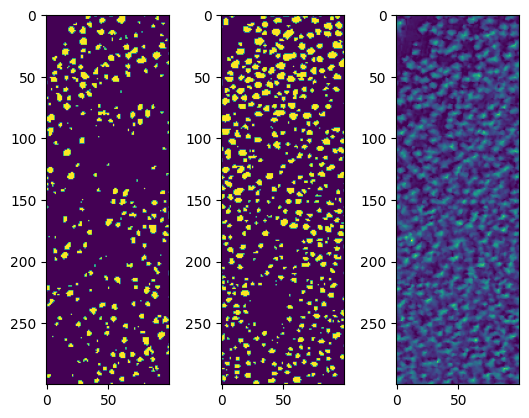

In [11]:
l2 = local[500:800,500:600]
l2_old = old_local[500:800,500:600]
l2_pan = local_pan[500:800,500:600]

fig2 = plt.figure()

fig2.add_subplot(1,3,1)
plt.imshow(l2)
fig2.add_subplot(1,3,2)
plt.imshow(l2_old)
fig2.add_subplot(1,3,3)
plt.imshow(l2_pan)

plt.show()

mean: pan(128.2509765625), ndvi(0.3377726376056671)
var: pan(2300.294554710388), ndvi(0.01986602321267128)


2022-12-09 17:58:11.268744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


1/1 [==============================] - 2s 2s/step


2022-12-09 17:58:12.773999: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

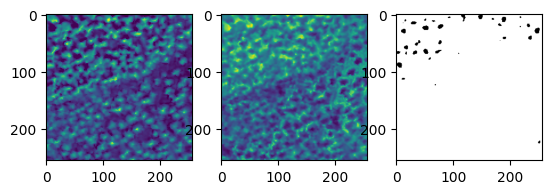

In [7]:
# inference local
# pan, ndvi, label, inference
tif_dir = '/home/lenovo/treeseg-dataset/inference_train_data/tif'
sample_dir = '/home/lenovo/treeseg-dataset/inference_train_data/inference_sample_128_nonorm'

r = 188
c = 56
pan_arr = np.asarray(read_method('Image')(f'{sample_dir}/r{r}c{c}-pan-0.png').resize((256,256)))
# pan_arr = np.zeros((256,256))
ndvi_arr = np.asarray(read_method('Image')(f'{sample_dir}/r{r}c{c}-ndvi-0.png').resize((256,256)))
# ndvi_arr = np.zeros((256,256))

pan_arr = pan[24064:24192, 7168:7296]
ndvi_arr = ndvi[24064:24192, 7168:7296]
pan_arr = np.asarray(Image.fromarray(pan_arr).resize((256,256)))
ndvi_arr = np.asarray(Image.fromarray(ndvi_arr).resize((256,256)))

print(f'mean: pan({np.mean(pan_arr)}), ndvi({np.mean(ndvi_arr)})')
print(f'var: pan({np.var(pan_arr)}), ndvi({np.var(ndvi_arr)})')

comb_img = np.transpose(np.stack((ndvi_arr, pan_arr),axis=0), axes=(1,2,0))
expand_img = comb_img[np.newaxis, :]
prediction = model.predict(expand_img, steps=1)
thr = 0.5
prediction[prediction>thr]=1
prediction[prediction<=thr]=0
prediction = np.squeeze(prediction)
# seg_map = Image.fromarray((prediction*255).astype(np.uint8))
# seg_map.show()

fig = plt.figure()

fig.add_subplot(1,3,1)
plt.imshow(pan_arr)
fig.add_subplot(1,3,2)
plt.imshow(ndvi_arr)
fig.add_subplot(1,3,3)
plt.imshow(prediction, cmap='binary')

plt.show()


In [ ]:

write_dir="/home/lenovo/treeseg-dataset/inference_train_data/test_model"
dataset_dir = "/home/lenovo/treeseg-dataset/inference_train_data/inference_sample_128"

areas = [130]
rows = [2]
cols = [1]
for a in areas:
    for r in rows:
        for c in cols:
            ndvi_img= read_method()(f"{dataset_dir}/pan-0-area{a}-r{r}c{c}.png").resize((256,256))
            pan_img= read_method()(f"{dataset_dir}/ndvi-0-area{a}-r{r}c{c}.png").resize((256,256))

            comb_img = np.stack((ndvi_img, pan_img), axis=0)
            comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
            comb_img = comb_img[np.newaxis,:]
            prediction = model.predict(comb_img, steps=1)
            prediction[prediction>0.5]=1
            prediction[prediction<=0.5]=0
            
            p=np.concatenate((comb_img , prediction), axis = -1)
            print(f"p shape: {p.shape}") # (1,256,256,3)
            print(prediction.shape) # (1,256,256,1)
            print(np.unique(prediction))
            display_images(p,titles=None, interpolation=None, save=True, dir=f"{write_dir}/area{a}-c{r}r{c}")

In [ ]:
# TODO
# 1. no-norm split & train
# 2. sample clean 